# Speech Recognition using Graphs

Team members: Adrian Löwenstein, Kiran Bacsa, Manuel Vonlanthen<br>
Date:         22.01.2018

## Problem Description

In this section we will describe in detail the problem we studied during the final project of the course "Network Tour of Data Science". We wanted to do speech recognition using the Graph/Network theory learned during the course. We were inspired by the kaggle competition "Tensor Flow Speech Recognition Challenge: Can you build an algorithm that understands simple speech commands" put up by google. In said competition the goal was to classify 20 distinct words. Words that do not belong to any of the 20 classes should be classified as "unknown". For the kaggle competition the TensorFlow library had to be used. For this purpose Google provided a large training data set (64'720 audio files) with known labels and an even larger test (150'000+ audio files) with unknown labels for them to evaluate the built algorithms. We, however, decided to only work with the provided training data, because the data set is large enough to perform statistically valid model evaluation and it this we we weren't dependant on the kaggle competition.<br>
<br>
The provided data set consists of 64'720 .wave files of length 1s, sampled with a sampling rate of $16$ kHz. Each audio files contain one of 30 possible spoken words. The files were created using crowd-sourcing, which means that the conditioning of the audio signal is not equal for all audio files. This led to very different noise levels, amplitudes, etc. Also the same speaker might have recorded different audio files. The 20 core words which have to be classified correctly are:

    - up, down
    - zero, one, two, three, four, five ,six ,seven, eight, nine
    - go, stop 
    - left, rigth
    - no, yes
    - off, on
In addition to these 20 words, 10 other words were provided inside the training set to train the algorithm to classify words which it should not react to as "unknown". The following "unknown" words are contained in the training data:

    - bed
    - bird, cat, dog, mouse
    - tree
    - happy
    - marvin, sheila
    - wow
<br>
At this point we want to empphasize that we did not study the problem suggested for the kaggle competition, but a slightly simplified one. First of all we did not restrict ourselves to using TensorFlow, in fact we did not use it at all. However, we did restrict ourselves to use Graph theory as central part of our classification algorithm. Our goal was, using only the provided training set, to build a classifier which calssifies the above listed core words as accurate as possible. In addition, all other words (the 10 additional words) should be classified as "unknown". This means we wanted to build a "word"-classifier for 21 different classes using graph theory.<br>
<br>
Mathematically, we can define the task as follows. We split up our training data set into a training set $S_t$ of some size N (we will later comment on its size) and a validation set $S_v$ of size $V \leq 64'720-N$, used to check how well the classifier works.
Using $\mathbf{x_n} \in S_t$, which is some training audio file $\mathbf{x_n} \in \mathbb{R}^D$, where $D = 1s\cdot 16kHz = 16000$ is the number of samples per audio file, we can build our training data matrix $\mathbf{X}^{\mathbf{N\times D}}$. Using $\mathbf{X}$ we want to learn a function $f(\mathbf{v_v}, \mathbf{X}): \mathbb{R}^{N+1\times D} \to \{1,2,3,...,21\}$, where $\mathbf{v_v}\in S_v$ is a validation audio file $\mathbf{v_v}\in\mathbb{R}^D$, such that the resulting estimated label $\hat{y_v} = f(\mathbf{v_V}, \mathbf{X})$ is equal to the correct label $y_v \in \{1,2,3,...,21\}$ for as many validation samples as possible. Hence, we use the accuracy measure defined as
$$acc = \frac{\sum_{i=1}^{K}\max[\min[(|y_k-\hat{y_k}|),1],0]}{K},$$
where $K$ is the number of tested samples $v_k$. We want to remark that the model could also work with a subset $\mathbb{v}\subseteq S_v$ (batch) instead of a single validation file $v_v$. In this case we define the cardinality of said subset $|\mathbb{v}|=K$ and the model would correspond to $f(\mathbb{v}, \mathbf{X}): \mathbb{R}^{(N+K)\times D} \to \{1,2,3,...,21\}^K$.

## Imports

In [1]:
import os
from os.path import isdir, join
from pathlib import Path
import pandas as pd
from tqdm import tqdm

# Math
import numpy as np
import scipy.stats
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa
import librosa.display
from scipy import sparse, stats, spatial
import scipy.sparse.linalg

# Machine learning
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.utils import shuffle
from sklearn.metrics import  confusion_matrix
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import cross_val_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import pandas as pd

# Benchmarking
import time

# Cutting 

from cut_audio import *

%matplotlib inline

## Recompute

**WARNING** If you set recompute to True this will reextract all featrues and re-classify all audio file, which will take several days, so do not do it. It is here for completeness so you can see how the steps were done during th project. We've already computed these steps and saved the results into pickle files. Our entire used data, as well as the pickle files can be found on "Link".

In [2]:
recompute = False

## Feature Extraction (Adrian)

Describe the data set....<br>
Describe the entire pipeline from audio file to feature vector for one audio dile...<br>
Shortly mentione other Features that were tried...<br>
Set up python function in which the features of the entire training set could be extracted and put it into a if recompute is true... <br>
Load the pickle with all features in them,...

In [3]:
# Load features
features_og = pd.read_pickle('./Features Data/cut_mfccs_all_raw_10_1028_20.pickle')
features_og.head()

info                                                                    \
  iteration                                               path   speaker word   
                                                                                
0         0  ../Project/data/train/audio/bed/988e2f9a_nohas...  988e2f9a  bed   
1         2  ../Project/data/train/audio/bed/6d818f6c_nohas...  6d818f6c  bed   
2         0  ../Project/data/train/audio/bed/93ec8b84_nohas...  93ec8b84  bed   
3         1  ../Project/data/train/audio/bed/a9abc695_nohas...  a9abc695  bed   
4         0  ../Project/data/train/audio/bed/a8cb6dda_nohas...  a8cb6dda  bed   

      mfcc                                                ...               \
  raw_mfcc                                                ...                
         0        1        2        3        4        5   ...          190   
0 -532.804 -373.747 -281.723 -259.193 -260.494 -258.983   ...       1.9078   
1 -407.218 -255.981  -163.47  -131.31 -112.495  -118.76   ...    -0.523793   
2 -466.171 -337.843 -244.057 -223.569 -248.308 -250.754   ...     -19.4222   
3 -556.172 -371.435 -267.924 -229.983 -221.044 -213.585   ...     -13.8834   
4 -483.963 -384.623 -221.676 -136.899 -108.406 -110.998   ...      9.02163   

                                                                           \
                                                                            
       191      192      193      194      195      196      197      198   
0 -6.68038 -12.3779 -7.88019 -4.89838  5.09246  5.23662  5.81571    2.533   
1 -2.98547  -3.1049 -10.3242 -19.2463 -25.6867 -23.1932 -13.7993 -17.9949   
2 -8.93999 -2.63587 -2.76918 -9.29244 -14.9003 -17.6517 -15.8084 -25.7532   
3 -18.6183 -15.9497 -13.2618 -9.06467 -12.7498 -12.3417 -14.7705 -19.5946   
4  2.85084 -1.81553 -2.05279  0.79797 -2.28227 -10.0107 -13.8224 -10.9754   

            
            
       199  
0  3.65357  
1   -12.81  
2 -30.9885  
3 -22.2862  
4 -9.73626  

[5 rows x 204 columns]

## Semi-Supervised Classification (Manuel)

Now that we have extracted some meaningful features from the raw data, we want to build a model that uses some training set $S_t$ of cardinality $|S_t|=N$, which can be used to classify the rest of the data (validation set). Our best classification was achived using multi-class semi-supervised classification on graphs, which we'll describe in this section.<br>
<br>
We found that using a training set of cardinality $|S_t| = N = 4800$ and a validation batch size of $|\mathbb{v}|= K = 200$ to be both computationally reasonable and yielding good results. This means that we use the same $N$ datapoints (feature vectors of audio files), of which we know the labels, to classify all other audio files (validation set), of which we pretend not to know the labels. The classification of the validation set (size $V$) is done batch-wise, i.e. $K$ files are classified simultaniously and we iterate trough the entire validation set, i.e. $V/k$ iterations are performed. Which $N$ datapoints are chosen to form the training set is determined randomly with a restriction that every word (or class) is represented equally. Thus, for $N = 4800$ we choose $160$ audio samples of every one of the 30 clases/words at random.<br>
<br>
In this section we will classify one batch of size $K = 200$ and while doing that explain the method of semi-supervised classification using graphs in detail.

### Create training set, validation set and Data Matrix 

In a first step, we create the label vector $\mathbf{y}\in\{1,2,3,...,21\}^{64'720}$ for all datapoints. In addition we plot the labels and the distribution of the classes.

We have 64720 datapoints over the entire dataset.


Text(0,0.5,'number of datapoints')

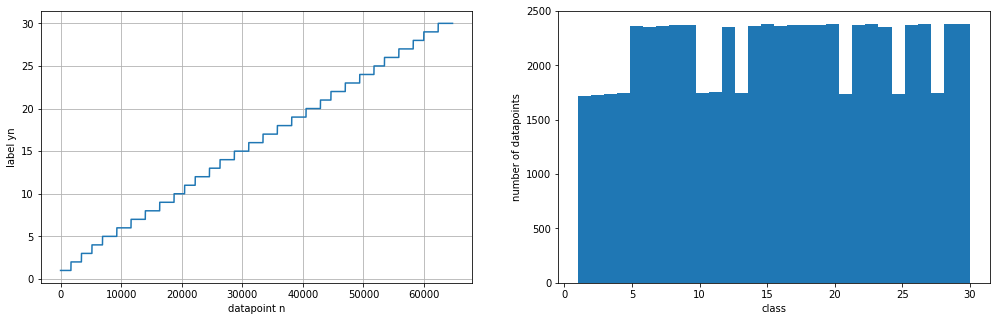

In [4]:
# Build Label vector
# Define class name vector, the index will correspond to the class label
class_names = features_og['info']['word'].unique()
y = np.ones(len(features_og))
for i in range(0,len(class_names)):
    y +=(features_og['info','word'] == class_names[i]) * i
    
# Plot the label vector
print('We have {} datapoints over the entire dataset.'.format(len(y)))
fix, axes = plt.subplots(1, 2, figsize=(17, 5))
axes[0].plot(y)
axes[0].grid()
axes[0].set_xlabel('datapoint n')
axes[0].set_ylabel('label yn')


# Plot distribution of classe
axes[1].hist(y,30)
axes[1].set_xlabel('class')
axes[1].set_ylabel('number of datapoints')

In the above histogram we can see that the classes are not balanced inside the test set. However, for our testing we will chose a balanced training, as well as a balanced validation step. Thi scorresponds to having an equal prior probability of occurence between the different words we want to classify. Thus, in the next cell we choose at random $160$ datapoints per class to form our training set $S_t$ ($30*160=4800$) and $1553$ datapoints per class to form the validation set $S_v$ ($1553*30 = 46590$), which is the maximum amount of datapoints we can put into the vlidation set for it to still be balanced.

In [5]:
# Specify the number of datapoints that should be sampled in each class to build training and validation set
train_size = 160
valid_size = 1553

train_x = np.array([])
train_y = np.array([])

valid_x = np.array([])
valid_y = np.array([])

for i in range(len(class_names)):
    class_index = np.where(y == (i+1))[0]
    random_index = np.random.choice(range(len(class_index)), size=train_size+valid_size, replace=False)
    
    train_x_class = class_index[random_index[:train_size]]
    train_y_class = y[train_x_class]
    train_x = np.append(train_x, train_x_class).astype(int)
    train_y = np.append(train_y, train_y_class).astype(int)

    valid_x_class = class_index[random_index[train_size:train_size+valid_size]]
    valid_y_class = y[valid_x_class]
    valid_x = np.append(valid_x, valid_x_class).astype(int)
    valid_y = np.append(valid_y, valid_y_class).astype(int)

We will define the batch sizem whcih defines how many validation samples areclassified simultaniously. Then we choose at random 200 datapoints of the validation set $S_v$ to build said batch. **Remark**: Although the training and the validation sets are both balanced, the bacth itself is not necessarily, because this would be an unreasonable constraint for the task.  

In [6]:
# Define batch size
batch_size = 200

# Choose datapoints from validation set at random to form a batch
potential_elements  = np.array(list(enumerate(np.array(valid_x))))
indices = np.random.choice(potential_elements[:,0].reshape(-1,), batch_size, replace=False)
# The batch index_variable contains the indices of the batch datapoints inside the complete dataset
batch_index = potential_elements[:,0].reshape(-1,)[indices]

Now we build our feature matrix $\mathbf{X}^{N+K\times D}$ by concatenating the feature vectors of all datapoints inside the training set $S_t$ and the batch datapoints. The feature are then normalized by substracting their mean, as well as dividing by the standard deviation. The feature normalizing step was found to have a ver significant effect on the resulting classification accuracy. 

In [7]:
# Build data matrix and normalize features
X = pd.DataFrame(features_og['mfcc'], np.append(train_x, batch_index))
X -= X.mean(axis=0)
X /= X.std(axis=0)
print('The data matrix has {} datapoints.'.format(len(X)))

The data matrix has 5000 datapoints.


### Build Graph from Data Matrix

We now want to build a graph from the earlier obtained data matrix. Every node in our graph will correspond to one datapoint (feature vector of one audio file). We use a weighted, undirected graph. The weight is very important for our application, since it gives us a measure of how similair the feature vectors of the two datapoints are. The undirectedeness is a logical conclusion of our edges being similitarity measures, which are inherently undirected.<br>
<br>
To build the weight matrix $W\in \mathbb{R}^{(N+K)\times (N+K)}$ we compute the cosine distance between each datapoint $\mathbf{x_n}$ in the datamatrix $\mathbf{X}$, which is defined as
$$d(\mathbf{x_i},\mathbf{x_j}) = \frac{\mathbf{x_i}^T\mathbf{x_j}}{||\mathbf{x_i}||_2||\mathbf{x_j}||_2}$$
and then build a similarity graph using
$$\mathbf{W_{i,j}} = exp(\frac{-d(\mathbf{x_i},\mathbf{x_j})^2}{\sigma^2}).$$
Other, distance functions were tested, but the cosine distance was found to be the most effective. We used the mean overall distance as $\sigma$.

The weight matrix has a shape of (5000, 5000).


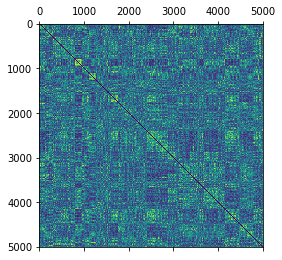

In [8]:
# Compute distances between all datapoints
distances = spatial.distance.squareform(spatial.distance.pdist(X,'cosine'))
n=distances.shape[0]

# Build weight matrix
kernel_width = distances.mean()
W = np.exp(np.divide(-np.square(distances),kernel_width**2))

# Make sure the diagonal is 0 for the weight matrix
np.fill_diagonal(W,0)
print('The weight matrix has a shape of {}.'.format(W.shape))

# Show the weight matrix
plt.matshow(W)

We can see a square pattern inside the weight matrix, which, since our weight matrix is more or less sorted by class (except the batch data points), points towards a clustering inside the graph corresponding to the classes. This is exactly what we wanted to achieve with good feature extraction and distance measures. Since the more the similarity graph is clustered (a cluster contaning the datapoints of the same classe), the more effective will our classification be.<br>
<br>
We now want to sparsify the graph, to have a more significant clustering. We use k-nearest neighbors approach for this.For the purpose of explaining the method we will keep $200$ strongest neighbors of each node. 

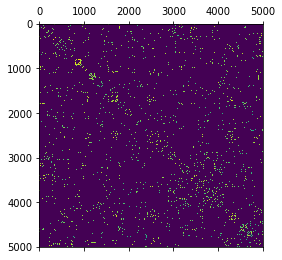

In [9]:
# Sparsify using k- nearest neighbours and make sure it stays symmetric
NEIGHBORS = 200

# Make sure
for i in range(W.shape[0]):
    idx = W[i,:].argsort()[:-NEIGHBORS]
    W[i,idx] = 0
    W[idx,i] = 0

plt.matshow(W) 

We can see that the sparsifyied weight matrix is very focused on its diagonal. We will finally build the normalized Laplacian, since it is the core graph feature we will use for semi-supervised classification. The normalized Laplacian is defined as
$$L = \mathbf{I}-\mathbf{D}^{-1/2}\mathbf{W}\mathbf{D}^{-1/2},$$
where $\mathbf{I}$ is the $(N+K)\times (N+K)$ identity matrix and $\mathbf{D}\in \mathbb{N}^{(N+K)\times (N+K)}$ is the degree matrix of the graph.

In [10]:
# Build normalized Laplacian Matrix
D = np.sum(W,axis=0)
L = np.diag(D**-0.5) @ (np.diag(D) - W) @ np.diag(D**-0.5)
L = sparse.csr_matrix(L)

### Perform semi-supervised classification

For the semi-supervised classification approach, we now want to transform the label vector of our training data $\mathbf{y_t} \in \{1,2,...,30\}^{N}$ into a matrix $\mathbf{Y_t}\in \{0,1\}^{30\times N}$. Each row $i$ of the matrix $\mathbf{Y_t}$ contains an indicator vector $\mathbf{y_{t,i}}\in\{0,1\}^N$ for class $i$, which means it contains a vector which specifyies for each training node in the graph if it belongs to node $i$ or not. 

In [11]:
# Build one-hot encoded class matrix
Y_t = np.eye(len(class_names))[train_y - 1].T
print('The shape of the new label matrix Y is {}, its maximum value is {} and its minimum value is {}.'.format(np.shape(Y_t),np.min(Y_t),np.max(Y_t)))

The shape of the new label matrix Y is (30, 4800), its maximum value is 0.0 and its minimum value is 1.0.


In the next cell we extend our label matrix $\mathbf{Y_t}$, such that there are labels (not known yet) for the validation datapoints we want to classify. Thus we extend the rows of $\mathbf{Y}$ by $K$ zeros, since the last $K$ nodes in the weight matrix of the used graph correspond to the validation points. We also create the masking matrix $\mathbf{M}\in\{0,1\}^{30\times (N+K)}$, which specifies which of the entries in $\mathbf{Y}$ are known (training) and which are unknown (validation).

In [12]:
# Create Mask Matrix
M = np.zeros((len(class_names), len(train_y) + batch_size))
M[:len(train_y),:len(train_y)] = 1

# Create extened label matrix and vector
Y = np.concatenate((Y_t, np.zeros((len(class_names), batch_size))), axis=1)
y = np.concatenate((train_y,np.zeros((batch_size,))))

Now comes the main part of semi-supervised classification. The method relies on the fact that we have a clustered graph, which gives us similarity measures between all the considered datapoints. The above mentioned class indicator vectors $\mathbf{y_i}$ (rows of $\mathbf{Y}$) are considered to be smooth signals on the graph, which is why achieving a clustered graph with good feature extraction was important.<br>
<br>
We try to fill in the gaps left in the label vector $\mathbf{y}$, i.e. estimating a $\mathbf{\hat{y}}\in \{1,2,...,30\}$, which should ideally be equal to the original label vector, i.e. containing the correctly classified labels for the validation datapoints. To achieve this we try to learn indicator vectors $\mathbf{\hat{y_i}} \in \mathbb{R}^{N+K}$ for each class $i$, which also contain labels for the validation points (unlike the afore mentioned $\mathbf{y_i}$). The higher the value $\mathbf{\hat{y_{i,j}}}$, the higher the probability that node $j$ belongs to class $i$. For this purpose, we solve the following optimization problem for each of the 30 classes, specified by $i\in \{1,2,...,30\}$.

$$ \underset{\mathbf{\hat{y_i}} \in \mathbb{R}^{N}}{argmin} \quad \frac{1}{2}||\mathbf{M_i}(\mathbf{y_i}-\mathbf{\hat{y_i}})||^2_2 + \frac{\alpha}{2} \mathbf{\hat{y_i}}^T\mathbf{L}\mathbf{\hat{y_i}} + \frac{\beta}{2}||\mathbf{\hat{y_i}}||_2^2$$ 

The matrix $\mathbf{M_i}$ is defined as the diagonal matrix containing the $i^{th}$ row of $\mathbf{M}$ on its diagonal.
The first term of the above depicted cost function is the fidelity term, which makes sure that the estimated vector $\mathbf{\hat{y_i}}$ is sufficiently close to the known entries of $\mathbf{y_i}$ (i.e. the labels of the training data points). The second term makes sure that the learned vector $\mathbf{\hat{y_i}}$ is smooth on the graph. The last term is there to make sure that we solve for a low energy verctor and avoid that the optimization problem is ill-posed. The two factors $\alpha, \beta >0$ are hyperparameters which give weight to their respective term or criterion.<br>
<br>
For the above described optimization problem we can find an explicit solution. For this, we first compute the gradient of the cost function with respect to $\mathbf{\hat{y_i}}$.

$$\nabla f(\mathbf{\hat{y_i}}) = -\mathbf{M_i}^T\mathbf{M_i}(\mathbf{y_i}-\mathbf{\hat{y_i}}) + \frac{\alpha}{2} (\mathbf{L}^T +\mathbf{L})\mathbf{\hat{y_i}} + \beta \mathbf{\hat{y_i}}$$

Using the fact that $\mathbf{M_i}$ is a diagonal, symmetric matrix containing only '1' and '0', as well as the fact that $\mathbf{L}$ is symmetric, we can simplify $\nabla \mathbf{f}$ to

$$\nabla f(\mathbf{\hat{y_i}}) = -\mathbf{M_i}(\mathbf{y_i}-\mathbf{\hat{y_i}}) + \alpha \mathbf{L} \mathbf{\hat{y_i}} + \beta \mathbf{\hat{y_i}}.$$

To find the solution $\mathbf{\hat{y_i}^*}$ to the optimization problem we set the gradient to 0 to obtain

$$\nabla f(\mathbf{\hat{y_i}^*}) = 0 = \mathbf{M_i}(\mathbf{y_i}-\mathbf{\hat{y_i}^*}) - \alpha \mathbf{L} \mathbf{\hat{y_i}^*} - \beta \mathbf{\hat{y_i}^*},$$

and thus

$$\mathbf{M_i y_i} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{(N+K)(N+K)}) \mathbf{\hat{y_i}^*}.$$

$\mathbf{I}_{(N+K)(N+K)}$ is the identity matrix of size $(N+K) \times (N+K)$. Introducing $\mathbf{y_{i,compr}} = \mathbf{M_i y_i}$ we can write

$$\mathbf{y_{i,compr}} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{(N+K)(N+K)}) \mathbf{\hat{y_i}^*}.$$

We define the matrix $\mathbf{A} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{(N+K)(N+K)})$ and now want to analyse its invertibility.<br>
<br>
We know that the Laplacian $\mathbf{L}$ is positive semi-definite (PSD), which means that all its eigenvlues are $\geq 0$. $M_i$ simply adds '1' to some of that eigenvalues, unfortunately not to all of them and thus it is not a sufficient criteria to render $\mathbf{A}$ full-ranlk an thus invertible. For this prupose we introduce the $l_2$-prior which adds $\beta >0$ to each eigenvalue, which makes $\mathbf{A}$ psoitive definite and thus invertible. I.e. by controlling $\beta$ our problem is well-posed and a unique solution $\mathbf{x_i^*}$ can be found.

$$\mathbf{x_i^*} = \mathbf{A^{-1}}\mathbf{y_{i,compr}}$$

Having found an $\mathbf{x_i}$ for every class $i$, we then build a matrix $\mathbf{X}\in \mathbb{R}^{30\times N}$, containing learned vectors $\mathbf{x_i}$ as its rows. The final labelling vector $\mathbf{\hat{x}}\in \{1,2,...,30\}$ is obtained by finding the row $i$ for each column $j$ of $\mathbf{X}$ in which the value is maximal and the index $i$ of the corresponding row will be the class $i$ of the datapoint (node) corresponding to the column $j$.

$$\mathbf{M_i y_i} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{NN}) \mathbf{x_i^*}.$$

$\mathbf{I}_{NN}$ is the identity matrix of size $N \times N$. Introducing $\mathbf{y_{i,compr}} = \mathbf{M_i y_i}$ we can write

$$\mathbf{y_{i,compr}} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{NN}) \mathbf{x_i^*}.$$

We define the matrix $\mathbf{A} = (\mathbf{M_i}+\alpha \mathbf{L} + \beta \mathbf{I}_{NN})$ and analyse its invertibility.
We know that the Laplacian $\mathbf{L}$ is positive semi-definite (PSD), which means that all its eigenvlues are $\geq 0$. $M_i$ simply adds '1' to some of that eigenvalues, unfortunately not to all of them and thus it is not a sufficient criteria to render $\mathbf{A}$ full-ranlk an thus invertible. For this prupose we introduce the $l_2$-prior which adds $\beta >0$ to each eigenvalue, which makes $\mathbf{A}$ psoitive definite and thus invertible. I.e. by controlling $\beta$ our problem is well-posed and a unique solution $\mathbf{x_i^*}$ can be found.

$$\mathbf{x_i^*} = \mathbf{A^{-1}}\mathbf{y_{i,compr}}$$

Having found an $\mathbf{x_i}$ for every class $i$, we then build a matrix $\mathbf{X}\in \mathbb{R}^{30\times N}$, containing learned vectors $\mathbf{x_i}$ as its rows. The final labelling vector $\mathbf{\hat{x}}\in \{1,2,...,30\}$ is obtained by finding the row $i$ for each column $j$ of $\mathbf{X}$ in which the value is maximal and the index $i$ of the corresponding row will be the class $i$ of the datapoint (node) corresponding to the column $j$.


## Method Validation (Kiran)

Describe that we tweaked parameters and which were found to be the optimal ones, comment on it...<br>
Show the resulting accuracy that resulted when going trough the entire training set. For this, simply load a pickle or numpy array, with the results in it and comment on it<br>
Add a .py funtion with which we could theoretically call to recompute the accuracy of the entire training set (in a "if recompute is true" conditioning). Add the function into main_pipeline.py. <br>
(Optional) Also add clustering approach to compare, otherwise we will just mention it...